In [15]:
%load_ext autoreload
%autoreload 2

from train import *
from models import *
from tools import load_data, get_label_dict, get_word_labels

from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import display

import numpy as np
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
X_train, y_train = load_data()
X_val, y_val = load_data('val')
X_test, _ = load_data('test')

y_train = to_categorical(y_train, 200)
y_val = to_categorical(y_val, 200)

Loading train data

Finished loading data

Loading val data

Finished loading data

Loading test data

Finished loading data



In [17]:
labels = get_label_dict()
test_images = os.listdir('data/tiny-imagenet-200/test/images/')
words = get_word_labels()

Loading labels

Done

Loading words

Done



In [18]:
def show_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [19]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             channel_shift_range=30., 
                             rescale=1./255)

testgen = ImageDataGenerator(rescale=1./255)

datagen.fit(X_train)

testgen.fit(X_val)
testgen.fit(X_test)

data = {'train': (X_train, y_train), 
        'val': (X_val, y_val)}

In [20]:
optim = optimizers.Adam(learning_rate=0.001)

In [21]:
model = AlphaNet()

In [22]:
checkpoint = ModelCheckpoint('models/' + model.name + '/' + model.name + ".h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             period=1)

cb_list = [checkpoint]

In [23]:
history = train(restore=False, 
                epochs=400,
                model=model, 
                optim=optim,
                datagen=datagen,
                data=data, 
                cb_list=cb_list)

Model: "AlphaNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        4736      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 64)        256

3125/3125 [==============================] - 154s 49ms/step - loss: 4.0347 - accuracy: 0.1404 - val_loss: 3.3991 - val_accuracy: 0.1904

Epoch 00015: val_accuracy improved from 0.18590 to 0.19040, saving model to models/AlphaNet/AlphaNet.h5
Epoch 16/400
3125/3125 [==============================] - 154s 49ms/step - loss: 4.0004 - accuracy: 0.1456 - val_loss: 3.3856 - val_accuracy: 0.1932

Epoch 00016: val_accuracy improved from 0.19040 to 0.19320, saving model to models/AlphaNet/AlphaNet.h5
Epoch 17/400
3125/3125 [==============================] - 155s 50ms/step - loss: 3.9763 - accuracy: 0.1487 - val_loss: 3.4965 - val_accuracy: 0.2006

Epoch 00017: val_accuracy improved from 0.19320 to 0.20060, saving model to models/AlphaNet/AlphaNet.h5
Epoch 18/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.9426 - accuracy: 0.1544 - val_loss: 3.0894 - val_accuracy: 0.2021

Epoch 00018: val_accuracy improved from 0.20060 to 0.20210, saving model to models/AlphaNet/AlphaNet.

3125/3125 [==============================] - 155s 49ms/step - loss: 3.4808 - accuracy: 0.2274 - val_loss: 3.4982 - val_accuracy: 0.2354

Epoch 00049: val_accuracy did not improve from 0.29030
Epoch 50/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.4753 - accuracy: 0.2271 - val_loss: 2.9390 - val_accuracy: 0.2916

Epoch 00050: val_accuracy improved from 0.29030 to 0.29160, saving model to models/AlphaNet/AlphaNet.h5
Epoch 51/400
3125/3125 [==============================] - 155s 49ms/step - loss: 3.4675 - accuracy: 0.2285 - val_loss: 2.7713 - val_accuracy: 0.2931

Epoch 00051: val_accuracy improved from 0.29160 to 0.29310, saving model to models/AlphaNet/AlphaNet.h5
Epoch 52/400
3125/3125 [==============================] - 155s 50ms/step - loss: 3.4602 - accuracy: 0.2309 - val_loss: 3.4592 - val_accuracy: 0.2915

Epoch 00052: val_accuracy did not improve from 0.29310
Epoch 53/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.4504 - accur

3125/3125 [==============================] - 155s 50ms/step - loss: 3.2493 - accuracy: 0.2648 - val_loss: 2.3397 - val_accuracy: 0.3362

Epoch 00087: val_accuracy improved from 0.33010 to 0.33620, saving model to models/AlphaNet/AlphaNet.h5
Epoch 88/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.2470 - accuracy: 0.2662 - val_loss: 3.1018 - val_accuracy: 0.3319

Epoch 00088: val_accuracy did not improve from 0.33620
Epoch 89/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.2410 - accuracy: 0.2668 - val_loss: 3.0426 - val_accuracy: 0.3355

Epoch 00089: val_accuracy did not improve from 0.33620
Epoch 90/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.2301 - accuracy: 0.2690 - val_loss: 3.3493 - val_accuracy: 0.3330

Epoch 00090: val_accuracy did not improve from 0.33620
Epoch 91/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.2401 - accuracy: 0.2675 - val_loss: 3.4552 - val_accuracy: 0.

3125/3125 [==============================] - 154s 49ms/step - loss: 3.1182 - accuracy: 0.2883 - val_loss: 2.5092 - val_accuracy: 0.3447

Epoch 00124: val_accuracy did not improve from 0.35590
Epoch 125/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.1119 - accuracy: 0.2916 - val_loss: 3.3242 - val_accuracy: 0.3589

Epoch 00125: val_accuracy improved from 0.35590 to 0.35890, saving model to models/AlphaNet/AlphaNet.h5
Epoch 126/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.1067 - accuracy: 0.2911 - val_loss: 3.7140 - val_accuracy: 0.3547

Epoch 00126: val_accuracy did not improve from 0.35890
Epoch 127/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.1144 - accuracy: 0.2891 - val_loss: 2.8111 - val_accuracy: 0.3530

Epoch 00127: val_accuracy did not improve from 0.35890
Epoch 128/400
3125/3125 [==============================] - 154s 49ms/step - loss: 3.1057 - accuracy: 0.2917 - val_loss: 3.2857 - val_accuracy

3125/3125 [==============================] - 149s 48ms/step - loss: 3.0156 - accuracy: 0.3074 - val_loss: 2.2887 - val_accuracy: 0.3673

Epoch 00162: val_accuracy did not improve from 0.37070
Epoch 163/400
3125/3125 [==============================] - 149s 48ms/step - loss: 3.0139 - accuracy: 0.3073 - val_loss: 2.3351 - val_accuracy: 0.3622

Epoch 00163: val_accuracy did not improve from 0.37070
Epoch 164/400
3125/3125 [==============================] - 148s 47ms/step - loss: 3.0092 - accuracy: 0.3078 - val_loss: 2.8882 - val_accuracy: 0.3671

Epoch 00164: val_accuracy did not improve from 0.37070
Epoch 165/400
3125/3125 [==============================] - 149s 48ms/step - loss: 3.0193 - accuracy: 0.3059 - val_loss: 1.8438 - val_accuracy: 0.3728

Epoch 00165: val_accuracy improved from 0.37070 to 0.37280, saving model to models/AlphaNet/AlphaNet.h5
Epoch 166/400
3125/3125 [==============================] - 149s 48ms/step - loss: 3.0113 - accuracy: 0.3078 - val_loss: 2.6226 - val_accuracy

Epoch 200/400
3125/3125 [==============================] - 149s 48ms/step - loss: 2.9486 - accuracy: 0.3192 - val_loss: 3.2044 - val_accuracy: 0.3784

Epoch 00200: val_accuracy did not improve from 0.38470
Epoch 201/400
3125/3125 [==============================] - 149s 48ms/step - loss: 2.9438 - accuracy: 0.3188 - val_loss: 2.5125 - val_accuracy: 0.3740

Epoch 00201: val_accuracy did not improve from 0.38470
Epoch 202/400
3125/3125 [==============================] - 148s 47ms/step - loss: 2.9452 - accuracy: 0.3195 - val_loss: 2.8501 - val_accuracy: 0.3825

Epoch 00202: val_accuracy did not improve from 0.38470
Epoch 203/400
3125/3125 [==============================] - 149s 48ms/step - loss: 2.9375 - accuracy: 0.3203 - val_loss: 3.1934 - val_accuracy: 0.3770

Epoch 00203: val_accuracy did not improve from 0.38470
Epoch 204/400
3125/3125 [==============================] - 149s 48ms/step - loss: 2.9288 - accuracy: 0.3221 - val_loss: 3.2355 - val_accuracy: 0.3708

Epoch 00204: val_accuracy

3125/3125 [==============================] - 149s 48ms/step - loss: 2.8862 - accuracy: 0.3293 - val_loss: 2.9612 - val_accuracy: 0.3862

Epoch 00238: val_accuracy did not improve from 0.39490
Epoch 239/400
3125/3125 [==============================] - 149s 48ms/step - loss: 2.8755 - accuracy: 0.3313 - val_loss: 2.8637 - val_accuracy: 0.3900

Epoch 00239: val_accuracy did not improve from 0.39490
Epoch 240/400
3125/3125 [==============================] - 149s 48ms/step - loss: 2.8787 - accuracy: 0.3300 - val_loss: 2.5112 - val_accuracy: 0.3895

Epoch 00240: val_accuracy did not improve from 0.39490
Epoch 241/400
3125/3125 [==============================] - 149s 48ms/step - loss: 2.8815 - accuracy: 0.3304 - val_loss: 1.7836 - val_accuracy: 0.3907

Epoch 00241: val_accuracy did not improve from 0.39490
Epoch 242/400
3125/3125 [==============================] - 149s 48ms/step - loss: 2.8708 - accuracy: 0.3325 - val_loss: 2.3794 - val_accuracy: 0.3917

Epoch 00242: val_accuracy did not impro

KeyboardInterrupt: 

In [24]:
show_history(history)

NameError: name 'history' is not defined

In [25]:
model = load_model('models/' + model.name + '/' + model.name + '.h5')
output = model.predict_generator(testgen.flow(X_test, shuffle=False))
results = []

for result in output:
    results.append(labels[np.argmax(result)])
    
assert len(results) == len(test_images)
print("Test images predicted:", len(results))

Test images predicted: 10000


In [26]:
with open('models/' + model.name + 
          '/' + model.name + ' Predictions.txt', 'w') as test_file:
    for i in range(len(results)):
        test_file.write(test_images[i] + ' ' + results[i] + '\n')

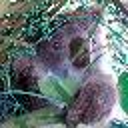

['koala,', 'koala', 'bear,', 'kangaroo', 'bear,', 'native', 'bear,', 'Phascolarctos', 'cinereus']


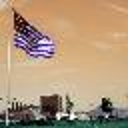

['flagpole,', 'flagstaff']


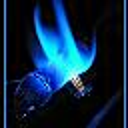

['torch']


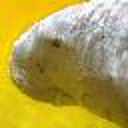

['dugong,', 'Dugong', 'dugon']


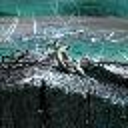

['American', 'alligator,', 'Alligator', 'mississipiensis']


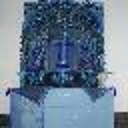

['altar']


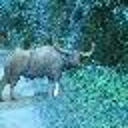

['bighorn,', 'bighorn', 'sheep,', 'cimarron,', 'Rocky', 'Mountain', 'bighorn,', 'Rocky', 'Mountain', 'sheep,', 'Ovis', 'canadensis']


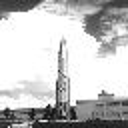

['crane']


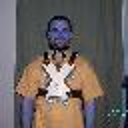

['neck', 'brace']


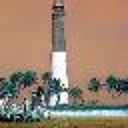

['beacon,', 'lighthouse,', 'beacon', 'light,', 'pharos']


In [27]:
for _ in range(10):
    index = np.random.randint(10000)
    img = Image.fromarray(X_test[index], 'RGB').resize(size=(128, 128))
    word_label = words[results[index]]
    display(img)
    print(word_label)